In [107]:
import pandas as pd
import numpy as np
from pathlib import Path
from tensorflow.keras import layers as L, models as M, backend as K, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import string

## №1 Подготовка данных

In [108]:
# Загрузка исходных данных
images = np.load(f'{Path.cwd()}/data/images.npy')
labels = np.load(f'{Path.cwd()}/data/labels.npy')
print(images.shape)
print(labels.shape)

(20000, 48, 48, 3)
(20000,)


In [109]:
# Нормализация данных
X_train = images / 255
X_train.shape

(20000, 48, 48, 3)

Сперва посмотрим на данные:

In [110]:
def show_first_letters(lines, columns, images):
    """
    Отображает первые строки и столбцы изображений с метками.
    
    :param lines: Количество строк для отображения
    :param columns: Количество столбцов для отображения
    :param images: Массив изображений
    """
    num_samples = lines * columns  # Сколько изображений показать
    plt.figure(figsize=(12, 9))
    # Выводим первые num_samples изображений
    for i in range(num_samples):
        plt.subplot(lines, columns, i+1)
        
        # Проверка формы изображения
        if images[i].shape[-1] == 1:  # черно-белые изображения
            plt.imshow(images[i][:, :, 0], cmap='gray')
        else:  # RGB
            plt.imshow(images[i])
        
        plt.title(f'Буква {string.ascii_uppercase[labels[i]]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Выведем первые несколько букв:

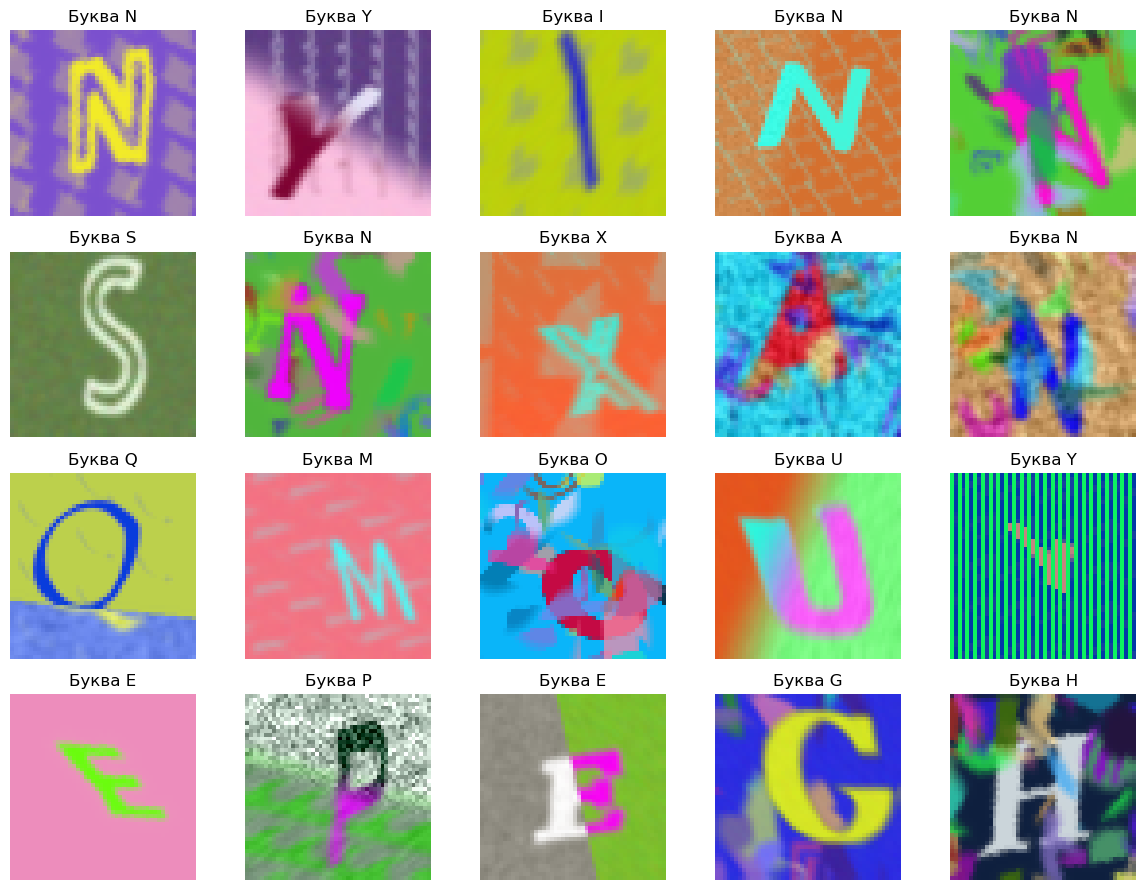

In [111]:
show_first_letters(4, 5, X_train)

Что если цвет только мешает - не несёт никакой информации и можно его убрать?

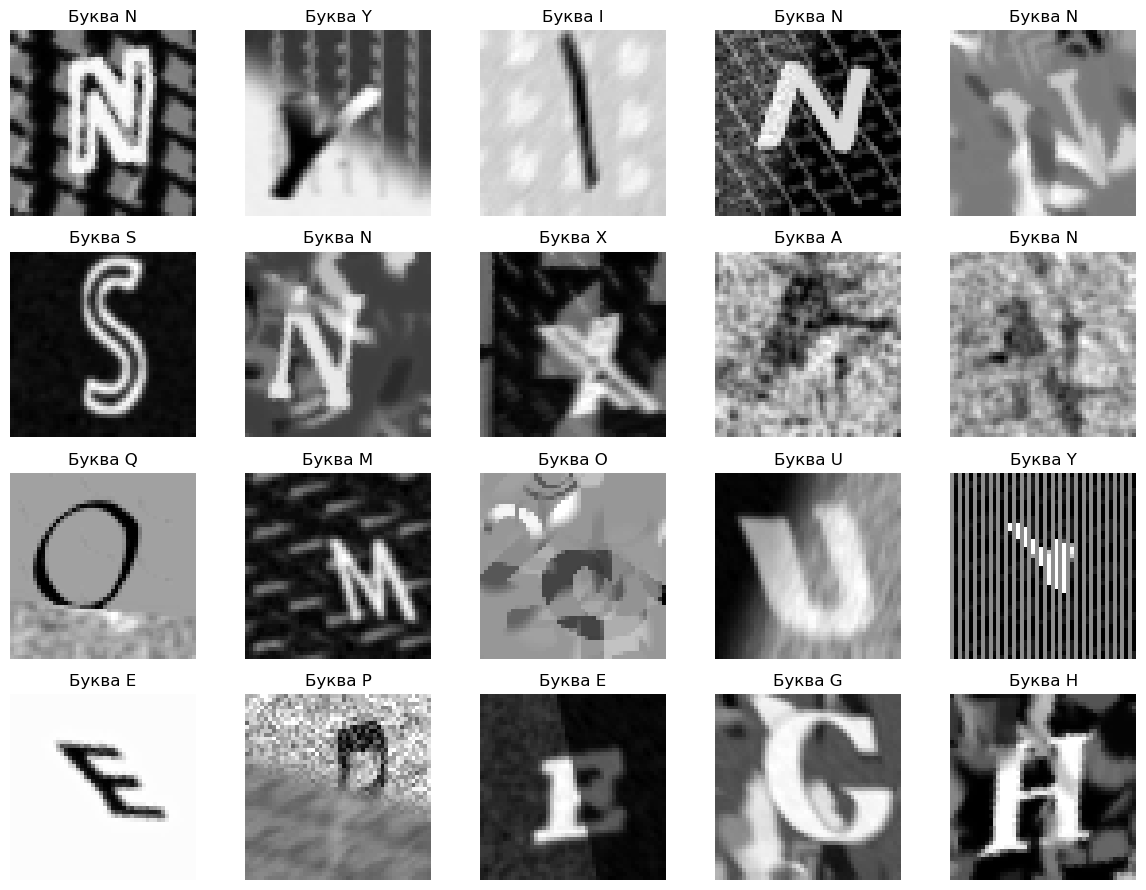

In [112]:
X_train_gray = X_train_gray = np.mean(images, axis=-1, keepdims=True) / 255.0
show_first_letters(4, 5, X_train_gray)

Кажется, некоторые буквы стали менее понятными - например А. Раассмтрим её поподробнее, по отдельным каналам и усреднённую версию:

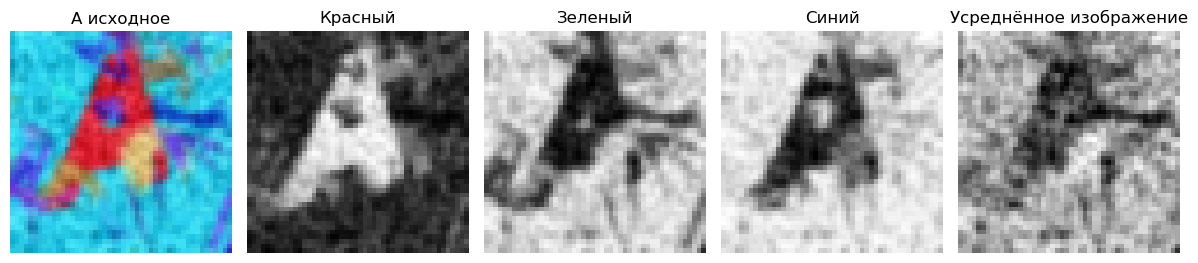

In [113]:
a_idx = 8  # Индекс буквы A
plt.figure(figsize=(12, 4))

# Исходное изображение
plt.subplot(1, 5, 1)
plt.imshow(X_train[a_idx])
plt.title('А исходное')
plt.axis('off')

for i, color in enumerate(['Красный', 'Зеленый', 'Синий']): # По каналам RGB
    plt.subplot(1, 5, i+2)
    plt.imshow(X_train[a_idx][:, :, i], cmap='gray')
    plt.title(color)
    plt.axis('off')

# усреднённое изображение по всем каналам
plt.subplot(1, 5, 5)
plt.imshow(X_train_gray[a_idx], cmap='gray')
plt.title('Усреднённое изображение')
plt.axis('off')
plt.tight_layout()
plt.show()

Кажется, лучше оставить цвета как есть

Аугментируем данные для увеличения разнообразия. Очень часто встречаются сильно наклонённые буквы, так что основной упор сделаем на наклон:

In [114]:
datagen = ImageDataGenerator(
    rotation_range=20,     # максимальный угол поворота - 25 градусов
    width_shift_range=0.1, # смещение влево и вправо на 10% от ширины изображения
    height_shift_range=0.1,# смещение вверх и вниз на 10% от высоты изображения
    zoom_range=0.1,        # масштабирование изображения на 10%
    horizontal_flip=False, # для букв горизонтальное отображение не нужно
    validation_split=0.2
)

train_generator = datagen.flow(X_train, labels, batch_size=128, subset='training')
val_generator = datagen.flow(X_train, labels, batch_size=128, subset='validation')

## №2 Создание и обучение модели

In [115]:
# создание модели
K.clear_session()
model = M.Sequential([
    L.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)), # сверточный слой
    L.BatchNormalization(),
    L.MaxPool2D(),

    L.Conv2D(128, (3, 3), padding='same', activation='relu'), # сверточный слой
    L.BatchNormalization(),
    L.MaxPool2D(),
    L.Dropout(0.2),

    L.Conv2D(256, (3, 3), padding='same', activation='relu'), # ещё один
    L.BatchNormalization(),
    L.MaxPool2D(),
    L.Dropout(0.2),

    L.Conv2D(512, (3, 3), padding='same', activation='relu'), # ещё один
    L.BatchNormalization(),
    L.MaxPool2D(),
    L.Dropout(0.2),

    L.Flatten(),
    L.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)), # добавляем регуляризацию
    L.BatchNormalization(),
    L.Dropout(0.2),
    L.Dense(26, activation='softmax'), # 26 классов для классификатора
])
model.summary()

model.compile(
    loss='sparse_categorical_crossentropy',  # дабы не one-hot-ить данные
    optimizer='adam',
    metrics=['accuracy']  # выводим процент правильных ответов
)

/home/vasiliy/miniconda3/envs/p312/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,305,178 (24.05 MB)

 Trainable params: 6,301,210 (24.04 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [116]:
# Обучение модели
history = model.fit(train_generator, validation_data=val_generator, epochs=15, verbose=1)

Epoch 1/15


/home/vasiliy/miniconda3/envs/p312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.0487 - loss: 5.7150 - val_accuracy: 0.0338 - val_loss: 5.5641
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.1991 - loss: 4.2927 - val_accuracy: 0.0930 - val_loss: 4.9216
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.4963 - loss: 2.8747 - val_accuracy: 0.2307 - val_loss: 3.9001
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.6325 - loss: 2.1452 - val_accuracy: 0.5863 - val_loss: 2.2121
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - accuracy: 0.7068 - loss: 1.7458 - val_accuracy: 0.7265 - val_loss: 1.5973
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.7530 - loss: 1.5005 - val_accuracy: 0.7423 - val_loss: 1.4896
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.7889 - loss: 1.3286 - val_accuracy: 0.7510 - val_loss: 1.4189
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.7980 - loss: 1.2417 - val

Добавим графики по истории обучения:

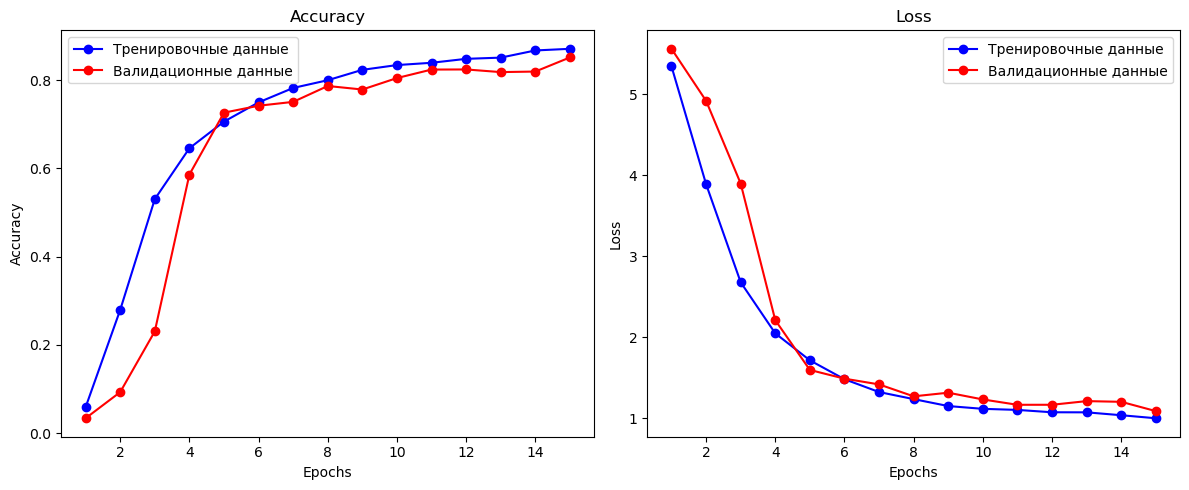

In [117]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# График Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Тренировочные данные')
plt.plot(epochs, val_accuracy, 'ro-', label='Валидационные данные')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# График Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Тренировочные данные')
plt.plot(epochs, val_loss, 'ro-', label='Валидационные данные')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## №3 Использование модели на images_sub

In [118]:
images_sub = np.load(f'{Path.cwd()}/data/images_sub.npy')
print(images_sub.shape)
X_test = images_sub / 255
# Предсказание классов для тестовых данных
predicted_classes = model.predict(X_test).argmax(axis=1)
# загружаем в csv файл для проверки
submission_df = pd.DataFrame({
    'Id': range(len(predicted_classes)),
    'Category': predicted_classes
})
submission_df.to_csv(f'{Path.cwd()}/data/submission.csv', index=False)

(50000, 48, 48, 3)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
